In [21]:
import numpy as np
from astropy import coordinates as coords
from astropy import units as u
from astroquery.sdss import SDSS
import pandas as pd
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery
import matplotlib.pyplot as plt

In [14]:
# Define the global boundaries of the region
ra_min = 120.0  # degrees
ra_max = 220.0  # degrees
dec_min = -10.0  # degrees
dec_max = 50.0  # degrees

# Define chunk size
chunk_size = 5.0  # degrees

# Calculate the total width and height
total_width = ra_max - ra_min
total_height = dec_max - dec_min

# Calculate the number of chunks in each dimension
n_chunks_ra = int(np.ceil(total_width / chunk_size))
n_chunks_dec = int(np.ceil(total_height / chunk_size))

# Define the r-band magnitude limit
psfmag_r_limit = 22.5

results_list = []

for i in range(n_chunks_ra):
    for j in range(n_chunks_dec):
        # Calculate RA and Dec ranges for this chunk
        ra1 = ra_min + i * chunk_size
        ra2 = min(ra1 + chunk_size, ra_max)
        dec1 = dec_min + j * chunk_size
        dec2 = min(dec1 + chunk_size, dec_max)

        # SQL query for this chunk
        query = f"""
        SELECT ra, dec, psfMag_g, psfMag_r
        FROM PhotoTag
        WHERE type = 6 AND mode = 1
        AND ra BETWEEN {ra1} AND {ra2}
        AND dec BETWEEN {dec1} AND {dec2}
        AND psfMag_r < {psfmag_r_limit}
        """

        print(f'Querying SDSS database for chunk: RA [{ra1:.2f}, {ra2:.2f}], Dec [{dec1:.2f}, {dec2:.2f}]')

        # Query SDSS database
        chunk_results = SDSS.query_sql(query, cache=False, timeout=3600)

        if chunk_results is not None:
            print(chunk_results['ra'][0])
            results_list.append(chunk_results)

# Combine all results
if results_list:
    results = pd.concat([r.to_pandas() for r in results_list], ignore_index=True)
    print(f"Total objects retrieved: {len(results)}")
else:
    print("No results retrieved.")
    

Querying SDSS database for chunk: RA [120.00, 125.00], Dec [-10.00, -5.00]
120.000595398827
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [-5.00, 0.00]
120.002195386393
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [0.00, 5.00]
120.005425107168
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [5.00, 10.00]
120.000020896228
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [10.00, 15.00]
120.000002651862
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [15.00, 20.00]
120.003831451266
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [20.00, 25.00]
120.000584732523
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [25.00, 30.00]
120.002208424071
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [30.00, 35.00]
120.000597463984
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [35.00, 40.00]
120.000012869229
Querying SDSS database for chunk: RA [120.00, 125.00], Dec [40.00, 45.00]
120.000605758015
Qu

In [ ]:
# Compute extinction
coords = SkyCoord(ra=results['ra'], dec=results['dec'], unit="deg", frame="icrs")
sfd = SFDQuery()
ebv = sfd(coords)

# Extinction coefficients for SDSS bands
coefficients = {
    "g": 3.793,
    "r": 2.751
}

# Calculate extinction values A_g and A_r
a_g = coefficients["g"] * ebv
a_r = coefficients["r"] * ebv

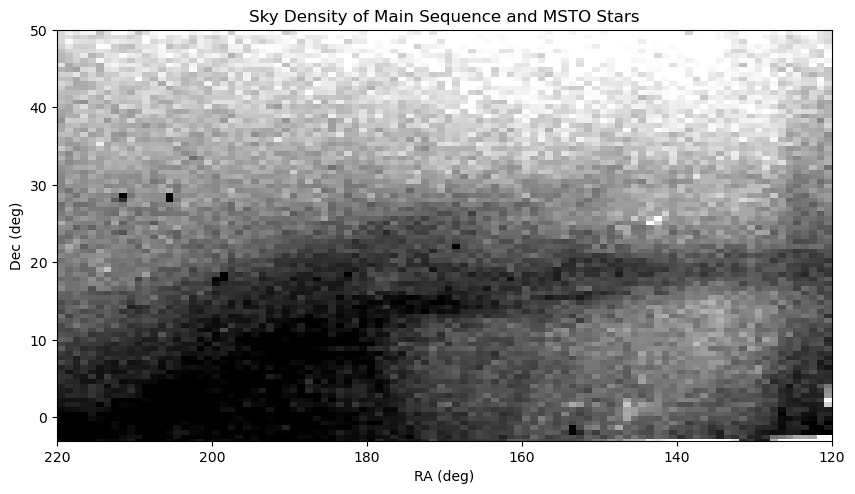

In [24]:
# Apply extinction correction
gmag = results['psfMag_g']-a_g
rmag = results['psfMag_r']-a_r

# Apply color-magnitude cuts for MS and MSTO stars
g_r = gmag-rmag
mask_msto = (g_r > 0.2) & (g_r < 0.4) & (rmag > 19.5) & (rmag < 22.5)

# Combine selections (if there are additional)
mask = mask_msto

# Extract positions of selected stars
selected = results[mask]
ra, dec = selected['ra'], selected['dec']

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(ra, dec, bins=100)

# Calculate 5th and 95th percentiles of non-zero values
non_zero = hist[hist > 0]
vmin, vmax = np.percentile(non_zero, [5, 95])

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the 2D histogram
im = plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                cmap='gray_r', norm=LogNorm(vmin=vmin, vmax=vmax))

# Set labels and title
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.xlim(ra_max, ra_min)
plt.ylim(-3, dec_max)
plt.title('Sky Density of Main Sequence and MSTO Stars')
plt.show()

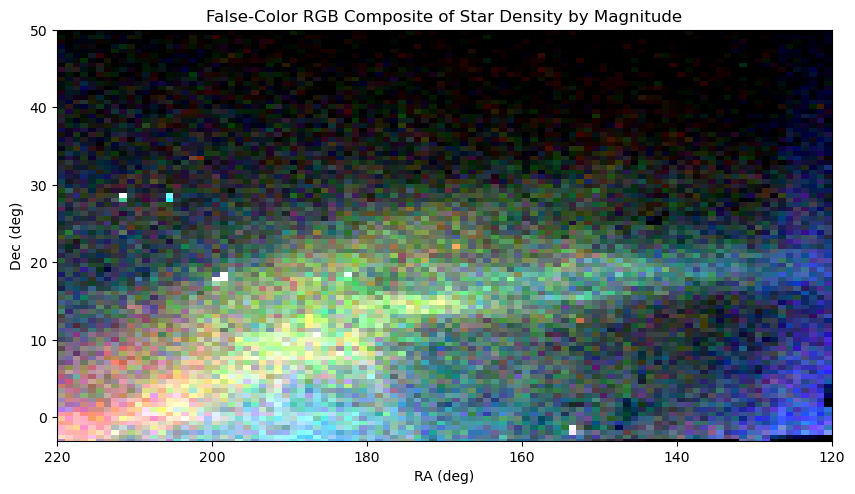

In [25]:
# False-colour RGB compoiste image
# --------------------------------

# Split data into 3 equal-size magnitude bins
mag_min = 20
mag_max = 22.5
mag_bins = np.linspace(mag_min, mag_max, 4)

# Compute 2D density for each bin
densities = []
for i in range(3):
    # Mag bin selection
    mask = (rmag >= mag_bins[i]) & (rmag < mag_bins[i+1])
    # Combine with MSTO seelction
    mask = mask_msto & mask
    ra = results.loc[mask, 'ra']
    dec = results.loc[mask, 'dec']

    # 2D histogram
    hist, xedges, yedges = np.histogram2d(ra, dec, bins=100)
    densities.append(hist)

# Normalize each channel individually using percentile scaling
def normalize_channel(channel):
    vmin, vmax = np.percentile(channel[channel > 0], [15, 98.5])
    return np.clip((channel - vmin) / (vmax - vmin), 0, 1)

# Each channel is rescaled and clipped
r_channel = normalize_channel(densities[2].T)  # Faintest stars
g_channel = normalize_channel(densities[1].T)  # Medium brightness stars
b_channel = normalize_channel(densities[0].T)  # Brightest stars

# Combine channels into RGB image
rgb_image = np.dstack((r_channel, g_channel, b_channel))

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(rgb_image, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.xlim(ra_max, ra_min)
plt.ylim(-3, dec_max)
plt.title('False-Color RGB Composite of Star Density by Magnitude')

plt.show()

